In [1]:
from sagemaker.processing import Processor, ProcessingInput, ProcessingOutput

In [2]:
import pandas as pd
import os 
import boto3
import pathlib

## Dataset
#### From Kaggle 
Link: https://www.kaggle.com/mmoreaux/environmental-sound-classification-50

you will need to log in with your google account to download this data

In [3]:
df=pd.read_csv('s3://feidemo/envsoundata/envSoundData/esc50.csv')

In [4]:
df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [5]:
dfclass=pd.read_csv('esc50broadclass.csv')

In [6]:
dfclass.columns=['category','broadclass']

In [7]:
dfclass['category']=df['category'].apply(lambda x: x.lower().replace(" ","_"))

In [8]:
classList=dfclass['broadclass'].unique().tolist()

In [9]:
dfclass['b_idx']=dfclass['broadclass'].apply(lambda x: dfclass['broadclass'].unique().tolist().index(x))

In [10]:
dfclass.head()

,category,broadclass,b_idx
0,dog,Animals,0
1,chirping_birds,Animals,0
2,vacuum_cleaner,Animals,0
3,vacuum_cleaner,Animals,0
4,thunderstorm,Animals,0


In [11]:
df2=df.merge(dfclass, how='inner')

In [12]:
df2.to_csv("s3://feidemo/envsoundata/envSoundData/labels.csv")

In [13]:
from IPython.display import Audio

In [14]:
's3://feidemo/envsoundata/envSoundData/audio/audio/44100/'+df[df['fold']==1].iloc[0]['filename']

's3://feidemo/envsoundata/envSoundData/audio/audio/44100/1-100032-A-0.wav'

In [15]:
s3=boto3.resource('s3')
s3.meta.client.download_file('feidemo','envsoundata/envSoundData/audio/audio/44100/1-100032-A-0.wav', 'testbin2.wav')

In [16]:
Audio('1-7974-B-49.wav', autoplay=False)

ValueError: rate must be specified when data is a numpy array or list of audio samples.

In [27]:
!aws s3 cp s3://feidemo/envsoundata/processed/Animals/1-75162-A-91_1_5.png animalsound.png
!aws s3 cp s3://feidemo/envsoundata/processed/Natural_soundscapes_\&\_water_sounds/1-101296-B-191_1_5.png nature.png

download: s3://feidemo/envsoundata/processed/Animals/1-75162-A-91_1_5.png to ./animalsound.png
download: s3://feidemo/envsoundata/processed/Natural_soundscapes_&_water_sounds/1-101296-B-191_1_5.png to ./nature.png


### What are Melspecs?

In [6]:
from IPython.display import Audio
Audio('1-101296-B-19.wav')



In [7]:
Audio('1-75162-A-9.wav')



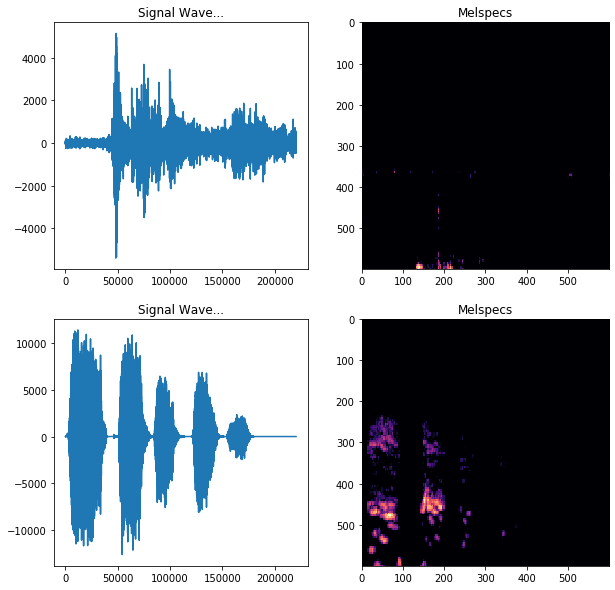

In [30]:
from PIL import Image
import matplotlib.pyplot as plt 
%matplotlib inline
import numpy as np
import wave
import sys

### Start with Audio File 
def plot_signal(Audfile):
    spf = wave.open(Audfile, "r")

    # Extract Raw Audio from Wav File
    signal = spf.readframes(-1)
    signal = np.fromstring(signal, "Int16")

    # If Stereo
    if spf.getnchannels() == 2:
        print("Just mono files")
        sys.exit(0)
    return signal

fig, axs = plt.subplots(2, 2,figsize=(10,10))



axs[0,0].set_title("Signal Wave...")
axs[0,0].plot(plot_signal('1-101296-B-19.wav'))

axs[1,0].set_title("Signal Wave...")
axs[1,0].plot(plot_signal('1-75162-A-9.wav'))

### Plot the corresponding Melspecs
axs[0,1].set_title("Melspecs")
img=Image.open('nature.png')
axs[0,1].imshow(img)

axs[1,1].set_title("Melspecs")
img=Image.open('animalsound.png')
axs[1,1].imshow(img)


plt.show()



### Let's use our own container to turn soundfiles into images.

In [25]:
!aws s3 ls s3://feidemo/envsoundata/envSoundData/

                           PRE audio/
2020-12-16 15:40:42       5481 bc_utils.py
2020-12-16 15:40:43      93742 esc50.csv
2020-12-16 22:31:36     153654 labels.csv
2020-12-16 15:40:42      10653 utils.py
2020-12-16 15:40:42       8060 utils2.py


In [ ]:
script_processor = ScriptProcessor(
    command=["python3"],
    image_uri=processing_repository_uri,
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
)

In [47]:
from sagemaker import get_execution_role

region = boto3.session.Session().region_name

role = get_execution_role()

processor = Processor(image_uri='973994155064.dkr.ecr.us-east-1.amazonaws.com/vkosound:latest',
                     role=role,
                     instance_count=1,
                     instance_type="ml.m5.xlarge")

processor.run(inputs=[ProcessingInput(
                        source='s3://feidemo/envsoundata/envSoundData/',
                        destination='/opt/ml/processing/input_data')],
                    outputs=[ProcessingOutput(
                        source='/opt/ml/processing/output_data/melspecs',
                        destination='s3://feidemo/envsoundata/processed')],
                    )


Job Name:  vkosound-2020-12-26-22-43-41-603
Inputs:  [{'InputName': 'input-1', 'S3Input': {'S3Uri': 's3://feidemo/envsoundata/envSoundData/', 'LocalPath': '/opt/ml/processing/input_data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'output-1', 'S3Output': {'S3Uri': 's3://feidemo/envsoundata/processed', 'LocalPath': '/opt/ml/processing/output_data/melspecs', 'S3UploadMode': 'EndOfJob'}}]
...............................received file /opt/ml/processing/input_data/audio/audio/44100/1-100032-A-0.wav
/opt/ml/processing/output_data/melspecs/Animals/
starting mfcc generation 
1
0.0 220500.0
/opt/ml/processing/output_data/melspecs/Animals/1-100032-A-01_1_5.png
/opt/ml/processing/output_data/melspecs/Animals/1-100032-A-01_1_5.png
received file /opt/ml/processing/input_data/audio/audio/44100/1-100032-A-0.wav
/opt/ml/processing/output_data/melspecs/Natural_soundscapes_&_water_sounds/
startin

In [40]:
!docker build -t sound .

Sending build context to Docker daemon  5.273MB
Step 1/45 : FROM ubuntu:16.04
 ---> 9499db781771
Step 2/45 : MAINTAINER rkadiy@amazon.com
 ---> Using cache
 ---> 0593e8d1e5b3
Step 3/45 : WORKDIR /home
 ---> Using cache
 ---> 64bbac3cf0dd
Step 4/45 : RUN mkdir code
 ---> Using cache
 ---> 601e984967fb
Step 5/45 : RUN mkdir code/samples
 ---> Using cache
 ---> 88837d48f0b8
Step 6/45 : RUN mkdir code/samples/libROSA
 ---> Using cache
 ---> e8b20469ccf6
Step 7/45 : RUN mkdir code/samples/TensorFlow
 ---> Using cache
 ---> 689825db2138
Step 8/45 : RUN mkdir workspace
 ---> Using cache
 ---> dc70a61f4878
Step 9/45 : RUN apt-get update   && apt-get install -y build-essential   wget   unzip   bzip2   software-properties-common   python-setuptools
 ---> Using cache
 ---> f8783a64df8f
Step 10/45 : RUN apt-get install -y libasound-dev    portaudio19-dev    libportaudio2    libportaudiocpp0    ffmpeg    libavcodec-extra
 ---> Using cache
 ---> 0cded026d105
Step 11/45 : WORKDIR /home/code
 ---> Usi

In [41]:
!docker images

REPOSITORY                                              TAG                 IMAGE ID            CREATED             SIZE
sound                                                   latest              a162a1ae9149        5 seconds ago       6.09GB
973994155064.dkr.ecr.us-east-1.amazonaws.com/vkosound   latest              1cc602cea2e7        9 days ago          6.09GB
973994155064.dkr.ecr.us-east-1.amazonaws.com/vkosound   <none>              2c5e26fd0985        9 days ago          6.09GB
973994155064.dkr.ecr.us-east-1.amazonaws.com/vkosound   <none>              31376057a632        9 days ago          6.09GB
973994155064.dkr.ecr.us-east-1.amazonaws.com/vkosound   <none>              b2aca0040f84        9 days ago          6.09GB
973994155064.dkr.ecr.us-east-1.amazonaws.com/vkosound   <none>              13c9f05e0777        9 days ago          6.08GB
ubuntu                                                  16.04               9499db781771        4 weeks ago         131MB


In [42]:
!aws ecr get-login --no-include-email

docker login -u AWS -p eyJwYXlsb2FkIjoieWszZWlpUlBEMDlzNFZHbUFlcytDbTd5eGRLYy90Y2F2c0M3aEs5STl4OGtGZ0VaeEcvdWcwdlErVGV6OFhDU1hWcWlIOUFsN2JWbHNaOEY4Qks5eHJZOU9nbXJMa1JkRmhpMkYrQ212OGpaemdRNVRKdElzQ3hxUUV0RjhabDFGK0tyUnA5MURFdlhnQUtMT0Z0MUplWU1wRGhhcW4vWFNiR2FsQ29sWS9IQW5Xck0xS21FNnlrYlBzcTdCUDB6N0luOXpsZ0J6dXU5S3Uwa2ZmTjNORldYNUlHb1N1QzFxL25SUlM5a2pKTDM5eGc0emxtVDB0UllhY24ycnhxVGt2QUF6WW00UjBIczMvQUZlRjErWTQyQmwvWGZrQ0t0WnlreGdUOWVOU1VUQ25uMWovb295T1FBaXJVZGtJdTAwNzZVbW1MMGpFaUc1MU9HVUpSVUxHaVJuOXF6SkNFUDU2cHI3N0RDWk42MGdaUTAvRGtRdmZDY0pncXVPTk8yTDI5WEpFdWJETngwcXZBa3czaDdwZ0xRczN1akJ6ZjczbER6UEp3RGx2RVo2TkFpM1FMWXQxWFF1RnRDanpMcGxha0ovV1E0cFhiRVo0Vzd4LzJNdVdITTN3RHc5cG5iMUhSRkJMUmp0UWlHYUpHcnZZU3hEalJEeDRJSzdzcjlUaVJMbmRRaGlKRm1WQjhwZmxlbU9pL2hJK0V3M2kwNHVmVDZkT085Rk5qZHpMQ3BsVGlDc2xkbGw3VW82NEx2dUlqNlNRT0k1Q0IralZ6L2VudE8xZDh0dmxCQWQzMmY4R1JLWnFqejhUS1NiMldyanpKN2tjVGJZancwTG9YVmZxaGhVc2dzeDRQYXJGalJlM2UxVGt3UUQvSXJGaExyYnRJMlIyeFVTUHRjK2JsbGp0MHR5UlNma2EzeTRkYnd3Lzk2UU9KWTlJUm9mVzAyU

In [43]:
!docker login -u AWS -p eyJwYXlsb2FkIjoieWszZWlpUlBEMDlzNFZHbUFlcytDbTd5eGRLYy90Y2F2c0M3aEs5STl4OGtGZ0VaeEcvdWcwdlErVGV6OFhDU1hWcWlIOUFsN2JWbHNaOEY4Qks5eHJZOU9nbXJMa1JkRmhpMkYrQ212OGpaemdRNVRKdElzQ3hxUUV0RjhabDFGK0tyUnA5MURFdlhnQUtMT0Z0MUplWU1wRGhhcW4vWFNiR2FsQ29sWS9IQW5Xck0xS21FNnlrYlBzcTdCUDB6N0luOXpsZ0J6dXU5S3Uwa2ZmTjNORldYNUlHb1N1QzFxL25SUlM5a2pKTDM5eGc0emxtVDB0UllhY24ycnhxVGt2QUF6WW00UjBIczMvQUZlRjErWTQyQmwvWGZrQ0t0WnlreGdUOWVOU1VUQ25uMWovb295T1FBaXJVZGtJdTAwNzZVbW1MMGpFaUc1MU9HVUpSVUxHaVJuOXF6SkNFUDU2cHI3N0RDWk42MGdaUTAvRGtRdmZDY0pncXVPTk8yTDI5WEpFdWJETngwcXZBa3czaDdwZ0xRczN1akJ6ZjczbER6UEp3RGx2RVo2TkFpM1FMWXQxWFF1RnRDanpMcGxha0ovV1E0cFhiRVo0Vzd4LzJNdVdITTN3RHc5cG5iMUhSRkJMUmp0UWlHYUpHcnZZU3hEalJEeDRJSzdzcjlUaVJMbmRRaGlKRm1WQjhwZmxlbU9pL2hJK0V3M2kwNHVmVDZkT085Rk5qZHpMQ3BsVGlDc2xkbGw3VW82NEx2dUlqNlNRT0k1Q0IralZ6L2VudE8xZDh0dmxCQWQzMmY4R1JLWnFqejhUS1NiMldyanpKN2tjVGJZancwTG9YVmZxaGhVc2dzeDRQYXJGalJlM2UxVGt3UUQvSXJGaExyYnRJMlIyeFVTUHRjK2JsbGp0MHR5UlNma2EzeTRkYnd3Lzk2UU9KWTlJUm9mVzAyUmVYaTJFcEE1bWJ1V2pUNWNaSStoQnpndTRJeXlCd1Iyd0hOZzFZZlNGbFJwK3phVnRRd01uYW1tMTNUcSt3RGg3NG4vdkFYeFRrZ0d3Nm8vYm11bERPWng1WUtFM2d2UitrNnpCeVJWbzhWanFhY2E4bVQ1NkhUaEJlS0duRGpwTTh2MEFEM1I3Vk1JUldpekQ1dlVETUsxZU0wa2xZbWdFQ3hXZjdicDBRYUNMbGFkSXkvTjNMb0J0eHMvTTFuVDFldUhRSHRpMytLVFdjNHZTNFkyWVZ1NUFHdU1vTEJ6Y0pvSDc4clZmK3RFblV6R3VDckZwRjZmdGdMS2llczk0dlM1UUJUSm9VNmY0Z3RXMGdBd3JjeVdFT3N4ZGp1S2JnekNpR3VQMnhpdGNYbnNaOS9jUmFsbmZnTDhwc1JLbTVrOWtBN1cycUtsbTJCd0dieE00VDF4SUtUQnZCdXExU0ZPL056TWZWMkVuT3pPejZmeWdKbTZaaVkvb0o4VzBBazRxdVJhaXk0N2lKeUZTLy9ELytIektUQkluRTAvZGY1ZGp5eG1SQ2FRZUY5SHJQbWpWMDVxeno5ZFhUcjdPVDhDdmNnN2VmbTBXQmlHN29UTkpkUkt2eStDa2VzVVBPd3UyNm1IczNkZkY4SFFZNXFsNGVPWUVsdzA3Y1JKYVQzckpkbTdQS1FPTXdWUEV1UkUwV2M0S1BLWWUxUDY1ZzRkODJVK2t4NHBLaHlOL3V5SnVjWWZ3Z1cyYWt0OGQvSEF0YTNtaXE5amc3QWRacHZFWFRvMHZwdjlzK0MxcUszNUwrK1NLOXJ0SXpuOXl3eFczczlKRmNxVHhXdnVybFVDUGZydUxoWHZXZS9raDhpdjV1M2RIRTFNRE5jNWViRVBLRHUranFWa1dqVVAyalJIZEpmdWdQVTZmbytpSFFPZWdaeDVLTEk4NzFYMlVxZGhNWm85MnhadURHQ2pMZlNNTi9sdzJCYkdvYjFEMUNlay9zRGlmOHdYaUFOalpMa0UwOGlFVURoa1QrZVlnPT0iLCJkYXRha2V5IjoiQVFFQkFIaHdtMFlhSVNKZVJ0Sm01bjFHNnVxZWVrWHVvWFhQZTVVRmNlOVJxOC8xNHdBQUFINHdmQVlKS29aSWh2Y05BUWNHb0c4d2JRSUJBREJvQmdrcWhraUc5dzBCQndFd0hnWUpZSVpJQVdVREJBRXVNQkVFREpwOGZiYVJ6YU9wRHBZbkZBSUJFSUE3WFhlWXRra0VuRE1CYkxEUWt4SmNHNHhlNXJBZWZSeU0wUmxRK2ZZbkRTdG16YnR0NjB4MkxYS2c3V0JPdllhdjRqQXkwcVFxYkdJTGhwdz0iLCJ2ZXJzaW9uIjoiMiIsInR5cGUiOiJEQVRBX0tFWSIsImV4cGlyYXRpb24iOjE2MDkwNjM3NDV9 https://973994155064.dkr.ecr.us-east-1.amazonaws.com

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded


In [9]:
!aws ecr create-repository --repository-name vkosound

{
    "repository": {
        "repositoryArn": "arn:aws:ecr:us-east-1:973994155064:repository/vkosound",
        "registryId": "973994155064",
        "repositoryName": "vkosound",
        "repositoryUri": "973994155064.dkr.ecr.us-east-1.amazonaws.com/vkosound",
        "createdAt": 1608162975.0,
        "imageTagMutability": "MUTABLE",
        "imageScanningConfiguration": {
            "scanOnPush": false
        },
        "encryptionConfiguration": {
            "encryptionType": "AES256"
        }
    }
}


In [44]:
!docker tag a162a1ae9149  973994155064.dkr.ecr.us-east-1.amazonaws.com/vkosound

In [45]:
!docker push 973994155064.dkr.ecr.us-east-1.amazonaws.com/vkosound

The push refers to repository [973994155064.dkr.ecr.us-east-1.amazonaws.com/vkosound]

0dbe4629: Preparing 
271d1311: Preparing 
f563dd18: Preparing 
81fcb302: Preparing 
77515f82: Preparing 
f4daed39: Preparing 
87732a00: Preparing 
c7411a64: Preparing 
ec1275f3: Preparing 
f376be7d: Preparing 
61f3dbf5: Preparing 
a1d6b676: Preparing 
034b0eb8: Preparing 
7d84a0e1: Preparing 
98b935f2: Preparing 
9dddf697: Preparing 
8c2e7eb3: Preparing 
854f104b: Preparing 
7732a00: Waiting g 
101e6ba1: Preparing 
1f3dbf5: Waiting g 
7411a64: Waiting g 
1d6b676: Waiting g 
c1275f3: Waiting g 
b839fa62: Preparing 
8b935f2: Waiting g 
30fc6edd: Preparing 
101e6ba1: Waiting g 
0527f96: Waiting g 
313baea: Waiting g 
c2e7eb3: Waiting g 
dddf697: Waiting g 
e3e3b262: Waiting g 
839fa62: Waiting g 
8ba4f576: Waiting g 
712f7523: Waiting g 
ac39ea85: Waiting g 
bc1e3b7c: Waiting g 
c8292d9b: Preparing 
74332e2e: Preparing 
563dd18: Pushed   80.57MB/75.39MBlatest: digest: sha256:3b5c1f205b5744bb8057c59ea7b2